In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train = train.drop_duplicates()

In [6]:
X = train.iloc[:, : -1]
y = train.iloc[:, -1]

In [7]:
train_2 = train
test_2 = test

In [8]:
train_2 = train_2.dropna()
test_2 = test_2.dropna()

In [9]:
X_2 = train_2.iloc[:, : -1]
y_2 = train_2.iloc[:, -1]

In [10]:
def insight(df):
    global categorical_columns, numerical_columns
    categorical_columns = df.select_dtypes(include=['object', 'bool']).columns
    numerical_columns = df.select_dtypes(exclude=['object', 'bool']).columns
    df_len = len(df)
    
    total_missing = df.isnull().sum().sum()
    
    missing_percentage = (total_missing / df_len) * 100
    
    print('Total items missing in the dataframe: {}({}%)'.format(total_missing, round(missing_percentage)))
    
    print('\n')
    print('-----------------')
    print('Numerical columns')
    print('-----------------')
    print('\n')
    for col in df[numerical_columns]:
        print(col)
        print('Min:', round(df[col].min(), 2))
        print('Max:', round(df[col].max(), 2))
        print('Mean:', round(df[col].mean(), 2))
          
        missing_num = df[col].isnull().sum()
    
        num_missing_percentage = (missing_num / df_len) * 100
        print('Missing items: {}({}%)'.format(missing_num, round(num_missing_percentage, 2)))
        
        print('\n')
    print('-------------------')
    print('Categorical columns')
    print('-------------------')
    print('\n')
    for col in df[categorical_columns]:
        print(col)
        print("{} unique items: ".format(len(df[col].unique())), df[col].unique())
        
        #print('Missing items:', df[col].isnull().sum())
        missing_cat = df[col].isnull().sum()
    
        cat_missing_percentage = (missing_cat / df_len) * 100
        print('Missing items: {}({}%)'.format(missing_cat, round(cat_missing_percentage, 2)))
        print('\n')
        
    
    

In [11]:
insight(X)

Total items missing in the dataframe: 2324(27%)


-----------------
Numerical columns
-----------------


Age
Min: 0.0
Max: 79.0
Mean: 28.83
Missing items: 179(2.06%)


RoomService
Min: 0.0
Max: 14327.0
Mean: 224.69
Missing items: 181(2.08%)


FoodCourt
Min: 0.0
Max: 29813.0
Mean: 458.08
Missing items: 183(2.11%)


ShoppingMall
Min: 0.0
Max: 23492.0
Mean: 173.73
Missing items: 208(2.39%)


Spa
Min: 0.0
Max: 22408.0
Mean: 311.14
Missing items: 183(2.11%)


VRDeck
Min: 0.0
Max: 24133.0
Mean: 304.85
Missing items: 188(2.16%)


-------------------
Categorical columns
-------------------


PassengerId
8693 unique items:  ['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
Missing items: 0(0.0%)


HomePlanet
4 unique items:  ['Europa' 'Earth' 'Mars' nan]
Missing items: 201(2.31%)


CryoSleep
3 unique items:  [False True nan]
Missing items: 217(2.5%)


Cabin
6561 unique items:  ['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
Missing items: 199(2.29%)


Destination


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [13]:
insight(test)

Total items missing in the dataframe: 1117(26%)


-----------------
Numerical columns
-----------------


Age
Min: 0.0
Max: 79.0
Mean: 28.66
Missing items: 91(2.13%)


RoomService
Min: 0.0
Max: 11567.0
Mean: 219.27
Missing items: 82(1.92%)


FoodCourt
Min: 0.0
Max: 25273.0
Mean: 439.48
Missing items: 106(2.48%)


ShoppingMall
Min: 0.0
Max: 8292.0
Mean: 177.3
Missing items: 98(2.29%)


Spa
Min: 0.0
Max: 19844.0
Mean: 303.05
Missing items: 101(2.36%)


VRDeck
Min: 0.0
Max: 22272.0
Mean: 310.71
Missing items: 80(1.87%)


-------------------
Categorical columns
-------------------


PassengerId
4277 unique items:  ['0013_01' '0018_01' '0019_01' ... '9271_01' '9273_01' '9277_01']
Missing items: 0(0.0%)


HomePlanet
4 unique items:  ['Earth' 'Europa' 'Mars' nan]
Missing items: 87(2.03%)


CryoSleep
3 unique items:  [True False nan]
Missing items: 93(2.17%)


Cabin
3266 unique items:  ['G/3/S' 'F/4/S' 'C/0/S' ... 'D/296/P' 'D/297/P' 'G/1498/S']
Missing items: 100(2.34%)


Destination
4 unique

2. EDA

[Text(0, 0, '2131'), Text(0, 0, '4602'), Text(0, 0, '1759')]

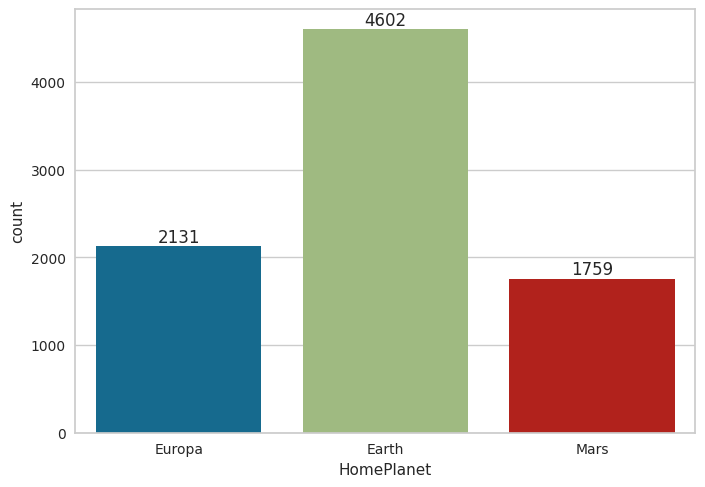

In [14]:
planet = sns.countplot(data=train, x='HomePlanet')
planet.bar_label(planet.containers[0])

[Text(0, 0, '5439'), Text(0, 0, '3037')]

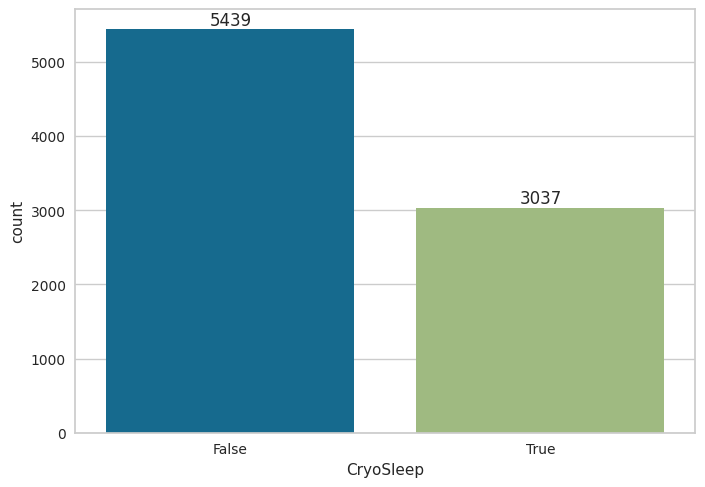

In [15]:
sleep = sns.countplot(data=train, x='CryoSleep')
sleep.bar_label(sleep.containers[0])

[Text(0, 0, '5915'), Text(0, 0, '796'), Text(0, 0, '1800')]

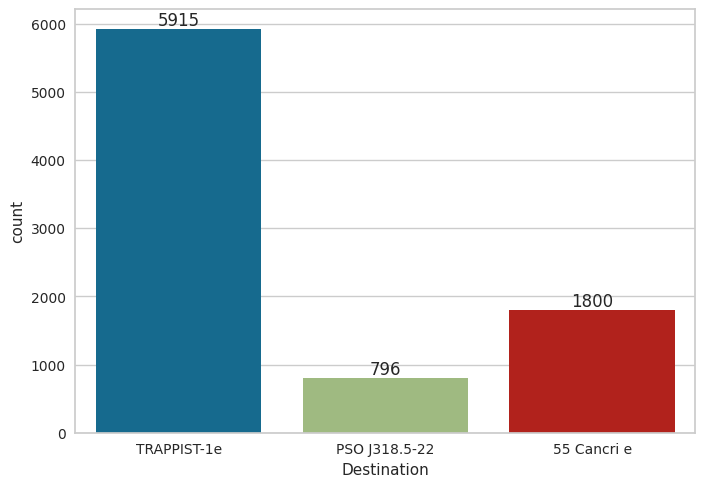

In [16]:
destination = sns.countplot(data=train, x='Destination')
destination.bar_label(destination.containers[0])

[Text(0, 0, '8291'), Text(0, 0, '199')]

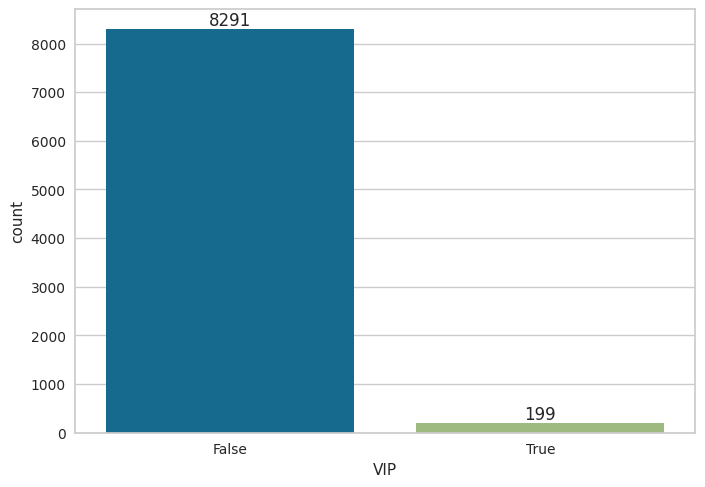

In [17]:
vip = sns.countplot(data=train, x='VIP')
vip.bar_label(vip.containers[0])

[Text(0, 0, '4315'), Text(0, 0, '4378')]

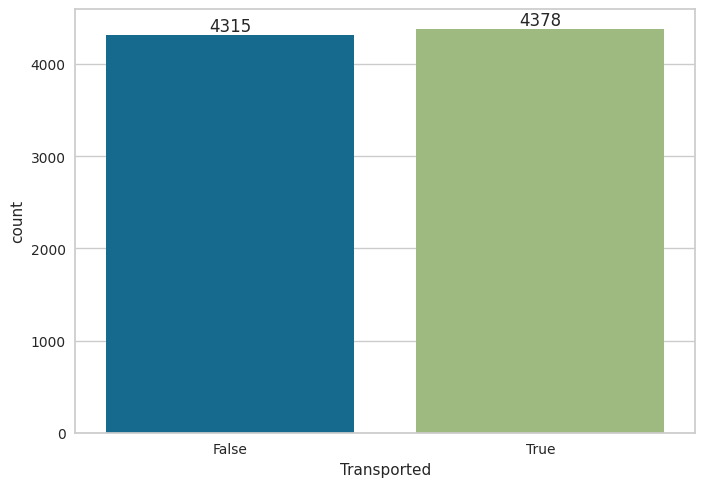

In [18]:
transported = sns.countplot(data=train, x='Transported')
transported.bar_label(transported.containers[0])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

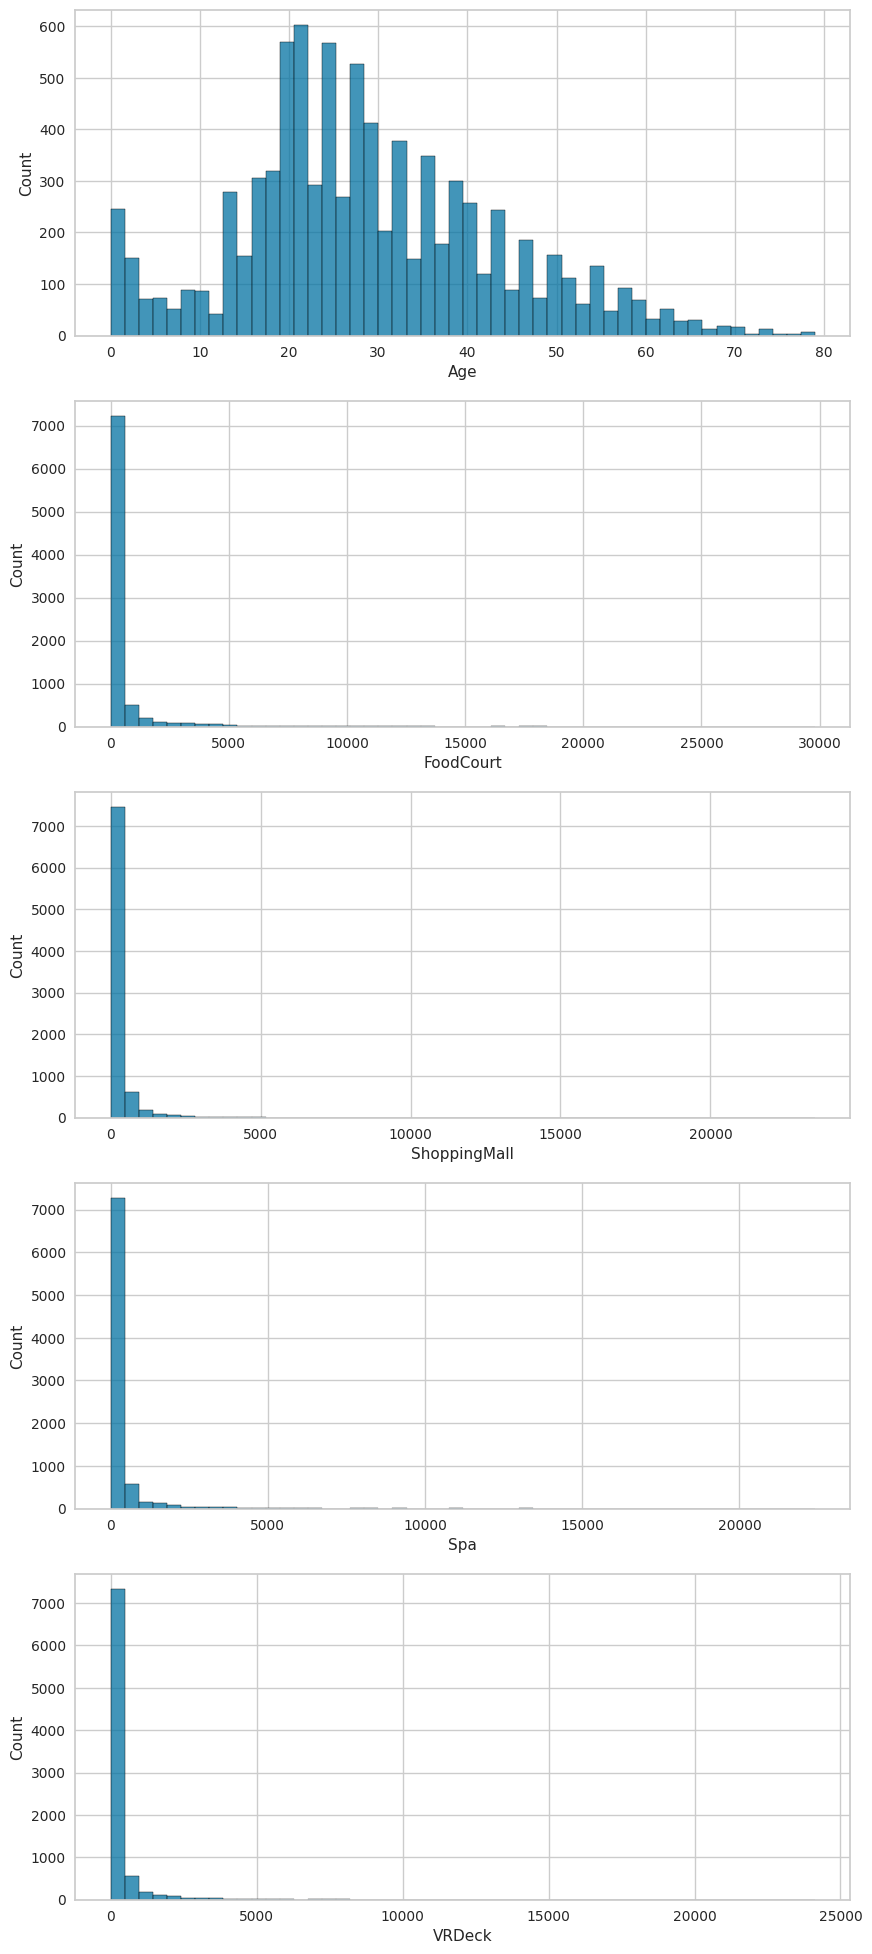

In [19]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(train['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(train['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(train['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(train['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(train['VRDeck'], color='b', bins=50, ax=ax[4]);

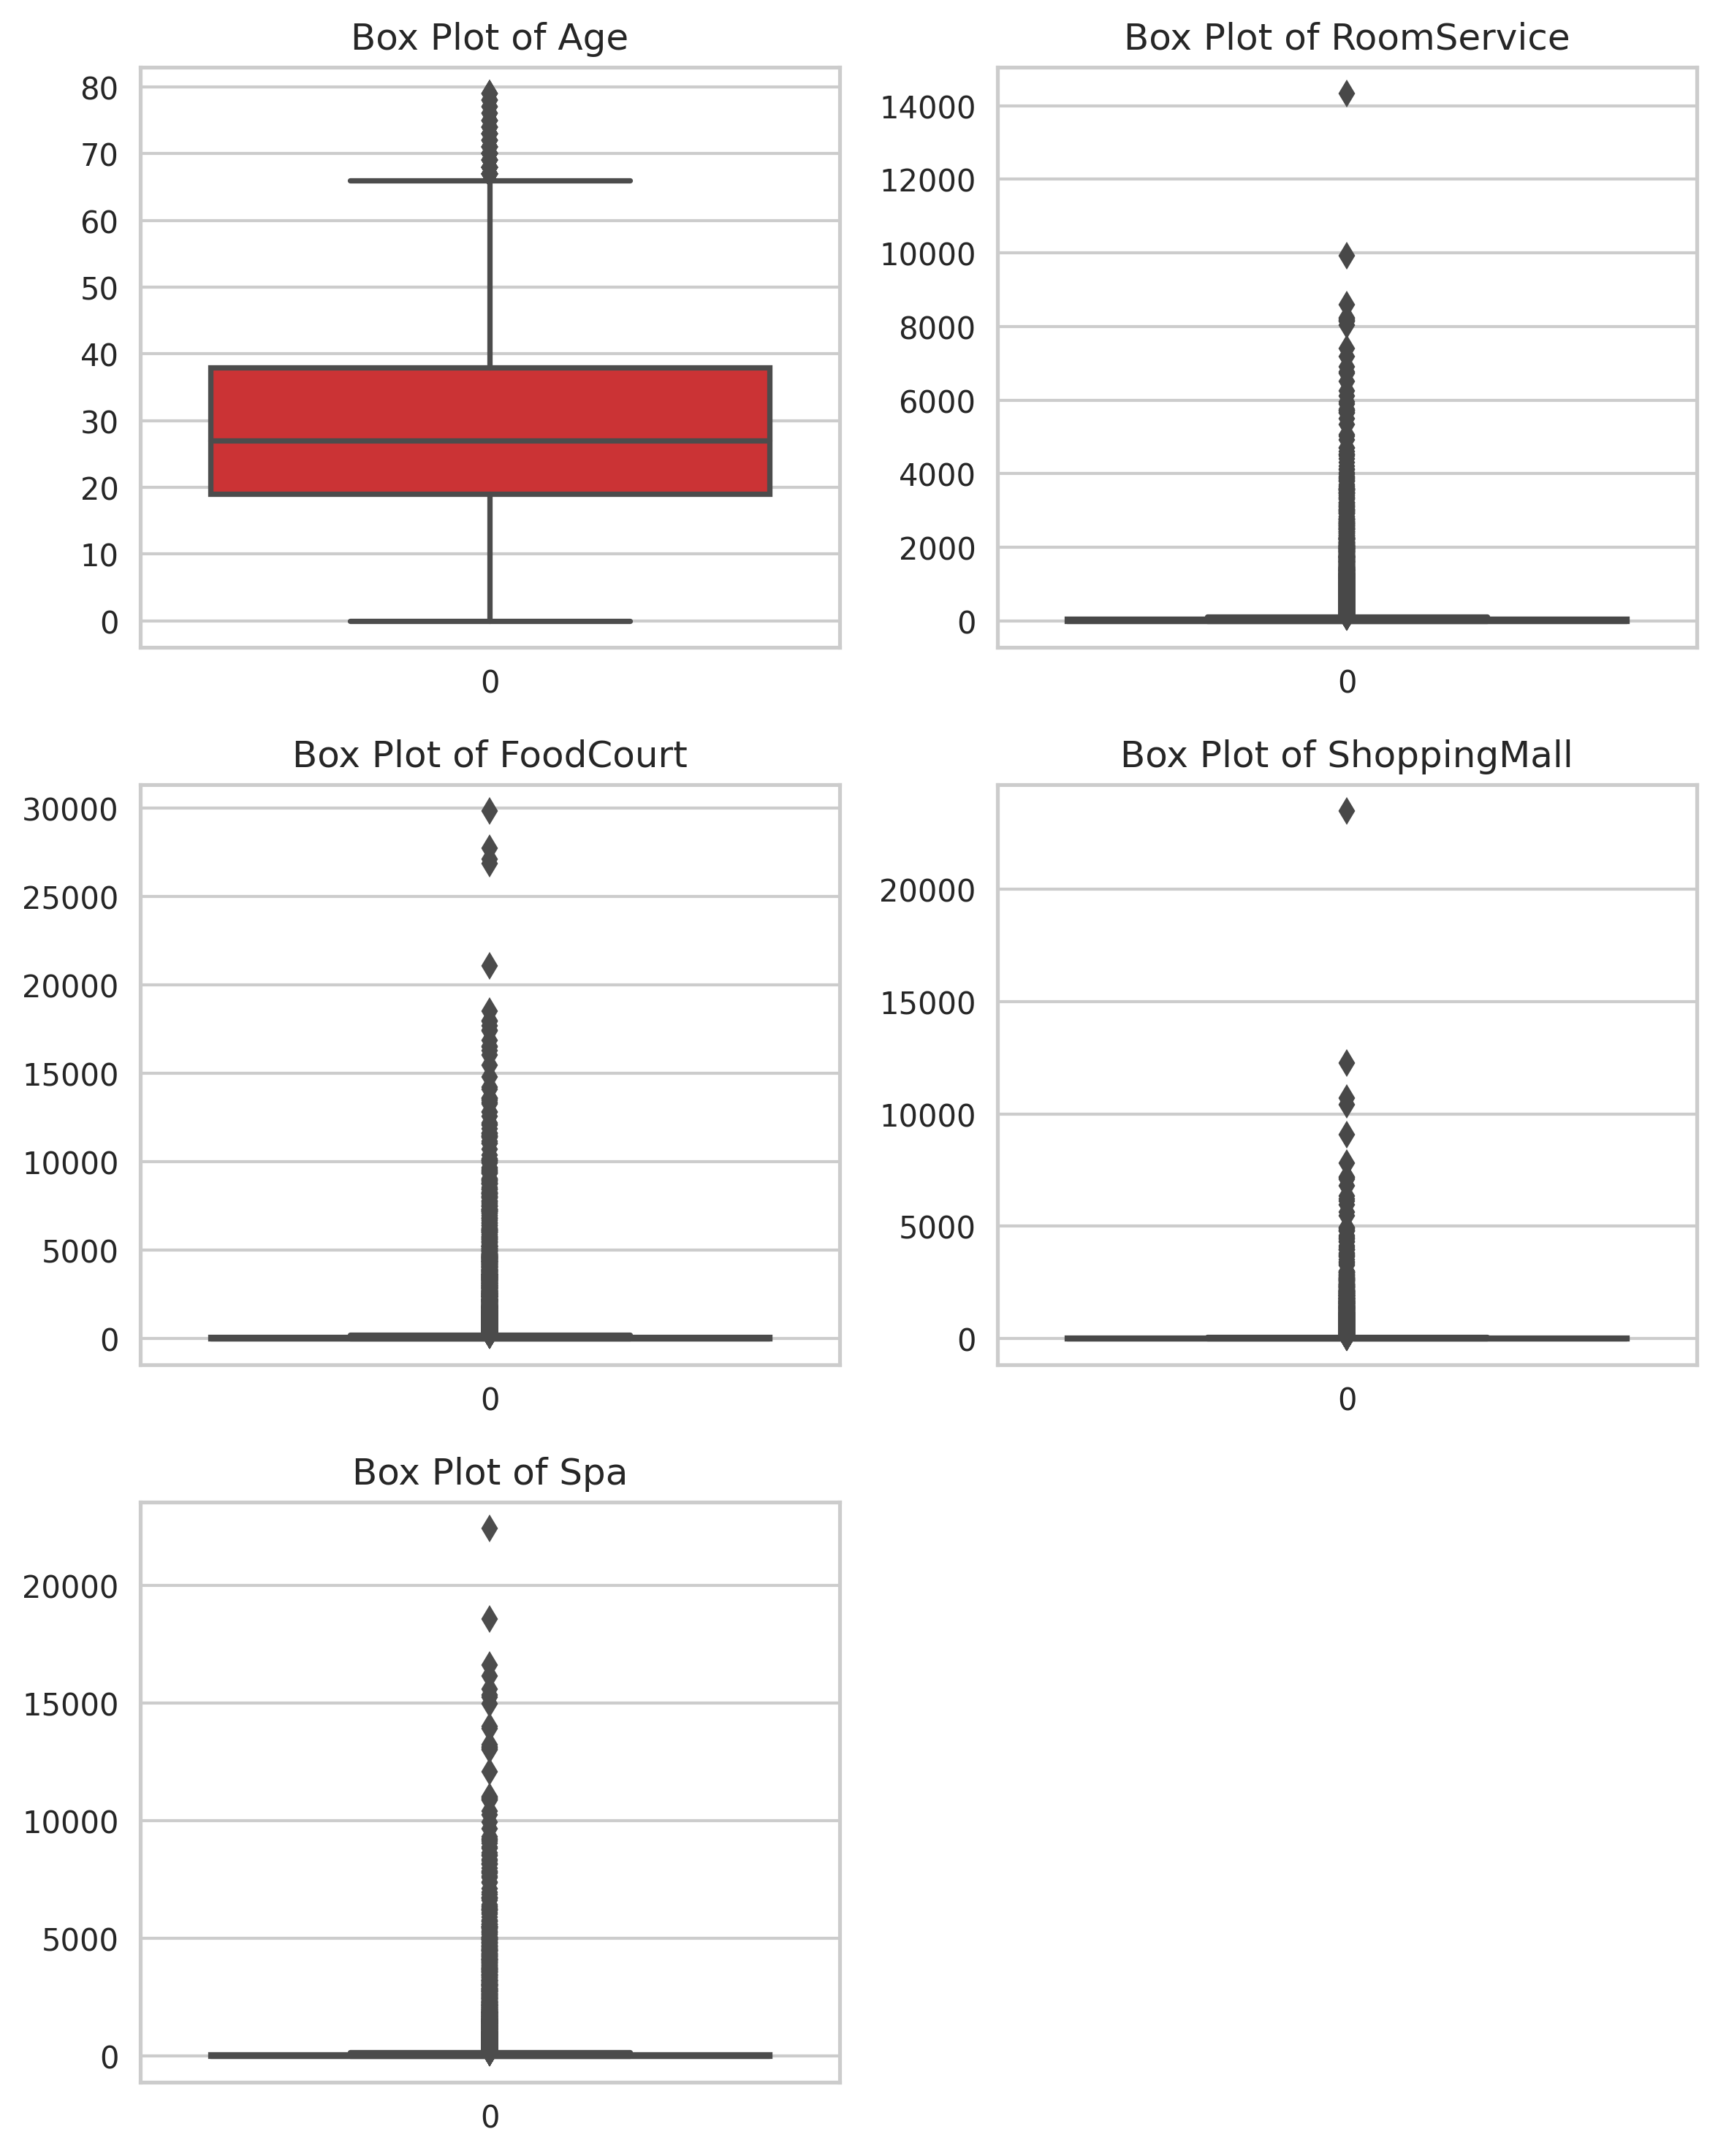

In [20]:

columns = numerical_columns[: -1].values
num_columns = len(columns)
num_rows = (num_columns + 1) // 2
colors = sns.color_palette("Set1", num_columns)
fig, axes = plt.subplots(num_rows, 2, figsize=(8, 10), dpi = 300)

#colors = sns.color_palette("Set1", num_columns)
for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.boxplot(data=train[column], ax=axes[row, col], color=colors[i])
    axes[row, col].set_title(f'Box Plot of {column}')

if num_columns % 2 != 0:
    axes[-1, -1].axis('off')

plt.tight_layout()
plt.show()

In [21]:
def outliers(data, a, b):
      # Calculate quartiles
    q1 = np.percentile(data, a)
    q3 = np.percentile(data, b)
    
    # Calculate interquartile range
    iqr = q3 - q1
    
    # Define the lower and upper bounds
    lower_threshold = q1 - 1.5 * iqr
    upper_threshold = q3 + 1.5 * iqr
    
    # Filter the data within the bounds
    outliers = [x for x in data if x < lower_threshold or x > upper_threshold]
    
    return outliers

In [22]:
outliers(train['Spa'], 25, 75)

[]

# Feature Engineering

In [23]:
X = X.drop('Name', axis=1)
test = test.drop('Name', axis=1)

In [24]:
X_2 = X_2.drop('Name', axis=1)
test_2 = test_2.drop('Name', axis=1)

In [25]:
encoder = LabelEncoder()

In [26]:
y = encoder.fit_transform(y)

In [27]:
scaler = StandardScaler()

In [28]:
#model = ExtraTreesClassifier()
#model.fit(X,y)

In [29]:
#X[['Group', 'GroupNumber']] = X['PassengerId'].str.split('_', expand=True)
#X['GroupNumber'] = X['GroupNumber'].astype(int)

In [30]:
#test[['Group', 'GroupNumber']] = test['PassengerId'].str.split('_', expand=True)
#test['GroupNumber'] = test['GroupNumber'].astype(int)

In [31]:
#X = X.drop('PassengerId', axis=1)
#test = test.drop('PassengerId', axis=1)

In [32]:
cat_to_fill = ['HomePlanet', 'CryoSleep', 'VIP', 'Destination', 'Cabin']

In [33]:
for col in cat_to_fill:
    X[col] = X[col].fillna(X[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])

/tmp/ipykernel_18/1690997226.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X[col] = X[col].fillna(X[col].mode()[0])
/tmp/ipykernel_18/1690997226.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[col] = test[col].fillna(test[col].mode()[0])


In [34]:
X[['Deck', 'DeckNumber', 'Side']] = X['Cabin'].str.split('/', expand=True)
X['DeckNumber'] = X['DeckNumber'].astype(int)


In [35]:
test[['Deck', 'DeckNumber', 'Side']] = test['Cabin'].str.split('/', expand=True)
test['DeckNumber'] = test['DeckNumber'].astype(int)

In [36]:
X = X.drop('Cabin', axis=1)
test = test.drop('Cabin', axis=1)

In [37]:
num_to_fill = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [38]:
for col in num_to_fill:
    X[col] = X[col].fillna(X[col].median())
    test[col] = test[col].fillna(test[col].median())

In [39]:
categorical_columns = X.select_dtypes(include=['object', 'bool']).columns
numerical_columns = X.select_dtypes(exclude=['object', 'bool']).columns

In [40]:
for col in categorical_columns:
    X[col] = encoder.fit_transform(X[col])
    test[col] = encoder.fit_transform(test[col])

In [41]:
categorical_columns_2 = X_2.select_dtypes(include=['object', 'bool']).columns
numerical_columns_2 = X_2.select_dtypes(exclude=['object', 'bool']).columns

In [42]:
for col in categorical_columns_2:
    X_2[col] = encoder.fit_transform(X_2[col])
    test_2[col] = encoder.fit_transform(test_2[col])

In [43]:
data_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(data_scaled, columns=X.columns)

In [44]:
data_scaled_2 = scaler.fit_transform(X_2)
X_2_scaled = pd.DataFrame(data_scaled_2, columns=X_2.columns)

In [45]:
test_data_scaled = scaler.fit_transform(test)
test_scaled = pd.DataFrame(test_data_scaled, columns=test.columns)

In [46]:
test_2_data_scaled = scaler.fit_transform(test_2)
test_2_scaled = pd.DataFrame(test_2_data_scaled, columns=test_2.columns)

In [47]:
X_2_scaled

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,-1.731789,0.417426,-0.738664,-1.528194,0.633005,0.695413,-0.158555,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534
1,-1.731264,-0.836561,-0.738664,-0.466701,0.633005,-0.336769,-0.158555,-0.176748,-0.279993,-0.266112,0.206165,-0.230494
2,-1.730740,0.417426,-0.738664,-1.613818,0.633005,2.002842,6.306963,-0.279083,1.845163,-0.309494,5.596357,-0.226058
3,-1.730215,0.417426,-0.738664,-1.613818,0.633005,0.282540,-0.158555,-0.345756,0.479034,0.334285,2.636384,-0.098291
4,-1.729691,-0.836561,-0.738664,-0.465442,0.633005,-0.887266,-0.158555,0.124056,-0.243650,-0.047470,0.220152,-0.267759
...,...,...,...,...,...,...,...,...,...,...,...,...
6601,1.729691,0.417426,-0.738664,-1.530082,-1.800299,0.833037,6.306963,-0.345756,3.777285,-0.309494,1.162518,-0.203876
6602,1.730215,-0.836561,1.353795,1.088392,-0.583647,-0.749641,-0.158555,-0.345756,-0.285355,-0.309494,-0.273759,-0.269534
6603,1.730740,-0.836561,-0.738664,1.091540,0.633005,-0.199145,-0.158555,-0.345756,-0.285355,2.938900,-0.272885,-0.269534
6604,1.731264,0.417426,-0.738664,-0.495033,-1.800299,0.213728,-0.158555,-0.345756,0.339621,-0.309494,0.034826,2.600774


In [48]:
model = ExtraTreesClassifier()
model.fit(X_scaled,y)

ExtraTreesClassifier()

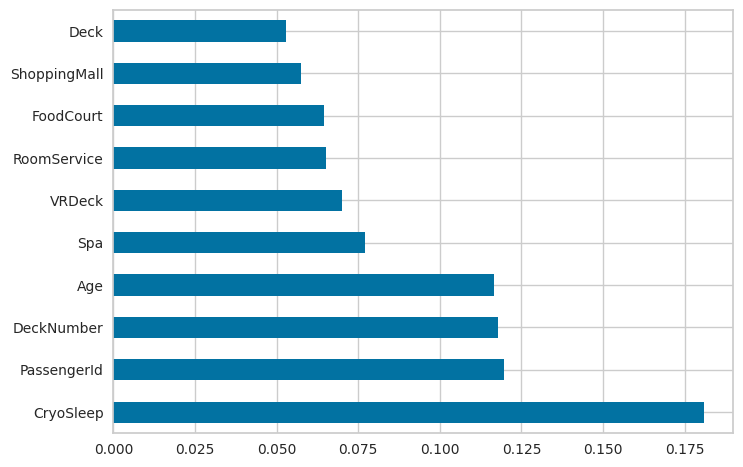

In [49]:
ranked_features = pd.Series(model.feature_importances_, index=X_scaled.columns)
ranked_features.nlargest(10).plot(kind='barh')
plt.show()

<Axes: >

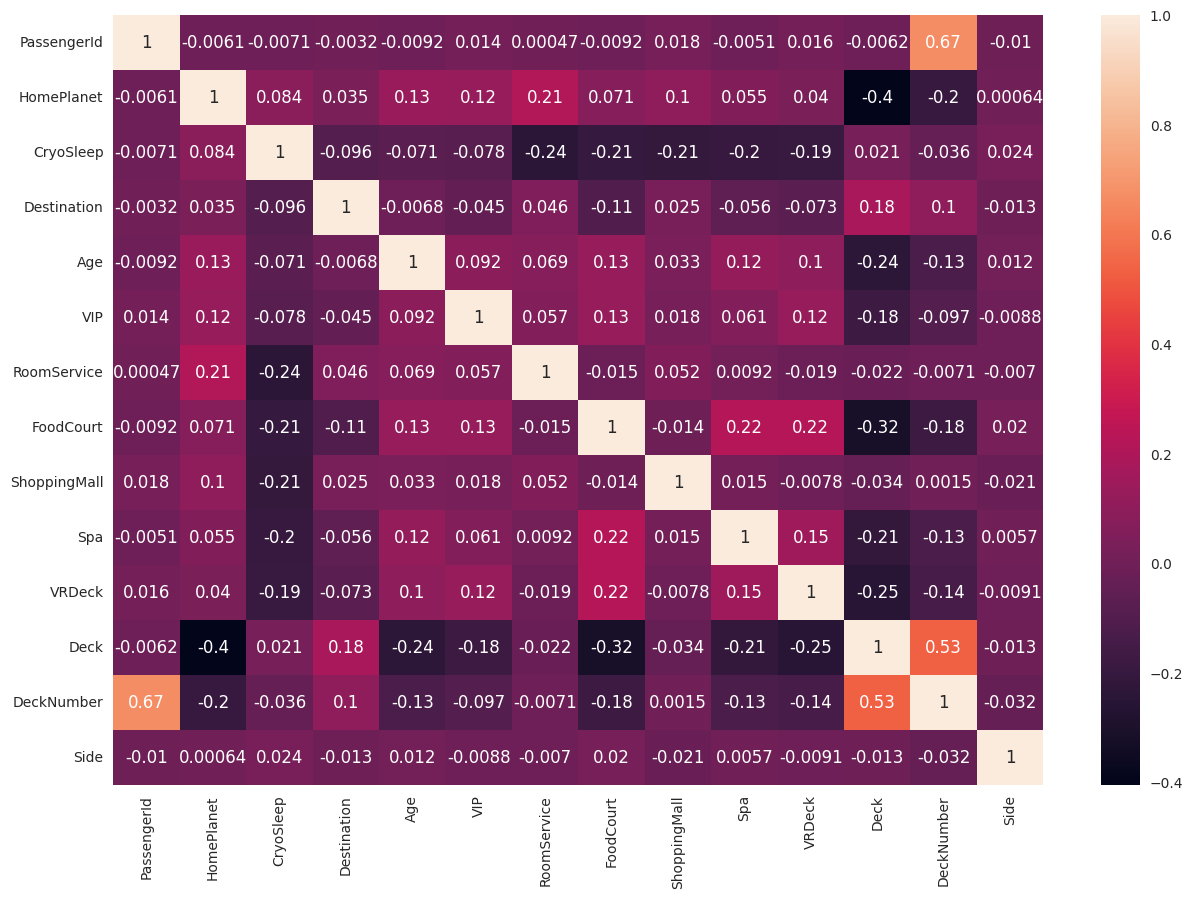

In [50]:
corr = X.corr()
plt.figure(figsize=(15,10))
sns.heatmap(X_scaled.corr(), annot=True)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [52]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2_scaled, y_2, test_size=0.3, random_state=42)

In [53]:
X_train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,DeckNumber,Side
3032,-0.523620,0.440385,-0.732770,0.620545,0.990874,-0.153063,-0.333105,0.621399,-0.283579,-0.195104,-0.130735,-1.883161,-0.954749,0.968181
7757,1.359260,0.440385,1.364685,0.620545,-0.403770,-0.153063,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,-1.320046,-0.652580,-1.032865
1795,-1.016556,-0.817259,-0.732770,0.620545,1.200071,-0.153063,-0.320992,0.127572,-0.283579,-0.266183,-0.183642,0.932414,-0.599256,0.968181
1702,-1.053616,-0.817259,-0.732770,0.620545,0.293552,-0.153063,-0.333105,0.197134,-0.270200,-0.268849,-0.236550,0.369299,-0.508408,0.968181
6634,0.911753,-0.817259,-0.732770,-1.833685,-0.334037,-0.153063,-0.333105,-0.244679,0.749913,-0.270626,-0.226850,0.369299,1.442853,0.968181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,0.553109,-0.817259,-0.732770,0.620545,-0.752431,-0.153063,-0.311908,-0.279773,-0.042765,0.271356,-0.263003,0.932414,0.759517,0.968181
5191,0.336727,1.698030,-0.732770,0.620545,1.478999,-0.153063,0.711588,-0.281027,-0.233409,0.406408,0.114401,0.369299,0.907639,0.968181
5390,0.416027,-0.817259,-0.732770,-0.606570,-0.473502,-0.153063,-0.093885,-0.281027,0.512444,-0.270626,-0.240077,0.369299,1.166359,-1.032865
860,-1.389147,1.698030,-0.732770,0.620545,0.363284,-0.153063,0.240720,-0.281027,2.435609,-0.270626,-0.263003,0.369299,-0.814527,-1.032865


In [54]:
#rf=RandomForestClassifier()
rf=RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=100)
#rf_parameters = {
    #'n_estimators': [50, 100, 150],
    #'max_depth': [None, 10, 20, 30],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4]
#}
#rf_grid_search = GridSearchCV(rf, rf_parameters, cv=5, n_jobs=-1,verbose=1, scoring='accuracy')
#rf_grid_search.fit(X_train, y_train)
#print ('Best score: %0.3f' % rf_grid_search.best_score_)
#print ('Best parameters set:')
#rf_best_parameters = rf_grid_search.best_estimator_.get_params()
#for param_name in sorted(rf_parameters.keys()):
    #print ('\t%s: %r' % (param_name, rf_best_parameters[param_name]))
#best_rf = rf_grid_search.best_estimator_
rf.fit(X_train, y_train)
#best_rf.fit(X_train, y_train)
#y_pred_rf = best_rf.predict(X_test)
y_pred_rf = rf.predict(X_test)
print(f"Accuracy:{accuracy_score(y_test, y_pred_rf)}")

Accuracy:0.7971625766871165


In [55]:
#rf=RandomForestClassifier()
rf_2=RandomForestClassifier(max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=150)
#rf_parameters = {
 #   'n_estimators': [50, 100, 150],
   # 'max_depth': [None, 10, 20, 30],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4]
#}
#rf_grid_search = GridSearchCV(rf, rf_parameters, cv=5, n_jobs=-1,verbose=1, scoring='accuracy')
#rf_grid_search.fit(X_2_train, y_2_train)
#print ('Best score: %0.3f' % rf_grid_search.best_score_)
#print ('Best parameters set:')
#rf_best_parameters = rf_grid_search.best_estimator_.get_params()
#for param_name in sorted(rf_parameters.keys()):
 #   print ('\t%s: %r' % (param_name, rf_best_parameters[param_name]))
#best_rf = rf_grid_search.best_estimator_
rf_2.fit(X_2_train, y_2_train)
#best_rf.fit(X_2_train, y_2_train)
#y_2_pred_rf = best_rf.predict(X_2_test)
y_2_pred_rf = rf_2.predict(X_2_test)
print(f"Accuracy:{accuracy_score(y_2_test, y_2_pred_rf)}")

Accuracy:0.8133198789101918


In [56]:
#dt = DecisionTreeClassifier()
dt = DecisionTreeClassifier(max_depth=160, min_samples_leaf=3, min_samples_split=3, criterion='entropy')
#dt_parameters = {
    #'max_depth': (150, 155, 160),
    #'min_samples_split': ( 2, 3),
    #'min_samples_leaf': (1, 2, 3),
    #'criterion' :['gini', 'entropy']}
#dt_grid_search = GridSearchCV(dt, dt_parameters, cv=5, n_jobs=-1,verbose=1, scoring='accuracy')
#dt_grid_search.fit(X_train, y_train)
#print ('Best score: %0.3f' % dt_grid_search.best_score_)
#print ('Best parameters set:')
#dt_best_parameters = dt_grid_search.best_estimator_.get_params()
#for param_name in sorted(dt_parameters.keys()):
    #print ('\t%s: %r' % (param_name, dt_best_parameters[param_name]))
#best_dt = dt_grid_search.best_estimator_
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(f"Accuracy:{accuracy_score(y_test, y_pred_dt)}")

Accuracy:0.758819018404908


In [57]:
#dt = DecisionTreeClassifier()
dt_2 = DecisionTreeClassifier(max_depth=150, min_samples_leaf=1, min_samples_split=2, criterion='entropy')
#dt_parameters = {
    #'max_depth': (150, 155, 160),
    #'min_samples_split': ( 2, 3),
    #'min_samples_leaf': (1, 2, 3),
    #'criterion' :['gini', 'entropy']}
#dt_grid_search = GridSearchCV(dt, dt_parameters, cv=5, n_jobs=-1,verbose=1, scoring='accuracy')
#dt_grid_search.fit(X_train, y_train)
#print ('Best score: %0.3f' % dt_grid_search.best_score_)
#print ('Best parameters set:')
#dt_best_parameters = dt_grid_search.best_estimator_.get_params()
#for param_name in sorted(dt_parameters.keys()):
    #print ('\t%s: %r' % (param_name, dt_best_parameters[param_name]))
#best_dt = dt_grid_search.best_estimator_
dt_2.fit(X_2_train, y_2_train)
y_2_pred_dt = dt_2.predict(X_2_test)
print(f"Accuracy:{accuracy_score(y_2_test, y_2_pred_dt)}")

Accuracy:0.760343087790111


In [58]:
predictions_rf = rf.predict(test_scaled)

predictions_dt = dt.predict(test_scaled)
predictions = [predictions_rf, predictions_dt]
model_names = ['rf', 'dt']
for pred, model_name in zip(predictions, model_names):
    submission["Transported"] = encoder.inverse_transform(pred)
    submission.to_csv(f'{model_name}_predictions.csv', index=False)
